,almacenamiento,espacio_por_planta,capacidad_maxima_plantas,costo_plantacion,dias_anticipacion,min_dias_aclimatacion,max_dias_aclimatacion,dias_simulacion,velocidad_camioneta,tiempo_maximo,tiempo_carga,carga_maxima,capacidad_maxima_transporte,costo_transporte,start_polygon
0,400.0,0.04,10000,20.0,1,3,7,10,40.0,6.0,0.5,524.0,8000.0,4500.0,6


,dia,especie,total,disponible,muy_joven,muy_vieja
0,2,especie 1,1111.0,0.0,1111,0.0
1,2,especie 2,673.0,0.0,673,0.0
2,2,especie 3,1111.0,0.0,1111,0.0
3,2,especie 4,1111.0,0.0,1111,0.0
4,2,especie 5,1313.0,0.0,1313,0.0
...,...,...,...,...,...,...
76,10,especie 5,1286.0,529.0,757,0.0
77,10,especie 6,1006.0,424.0,582,0.0
78,10,especie 7,831.0,151.0,543,137.0
79,10,especie 8,1168.0,0.0,990,178.0


,dia,poligono,especie,demanda_cubierta
0,1,1,especie 1,0.0
1,1,1,especie 2,0.0
2,1,1,especie 3,0.0
3,1,1,especie 4,0.0
4,1,1,especie 5,0.0
...,...,...,...,...
1705,10,19,especie 5,0.0
1706,10,19,especie 6,0.0
1707,10,19,especie 7,0.0
1708,10,19,especie 8,0.0


,dia_pedido,dia_entrega,especie,proveedor,cantidad
0,1,2,especie 1,Laguna Seca,3877.0
1,1,2,especie 2,Moctezuma,2350.0
2,1,2,especie 3,Proveedor 4,3877.0
3,1,2,especie 4,Moctezuma,3877.0
4,1,2,especie 5,Proveedor 4,4584.0
...,...,...,...,...,...
76,9,10,especie 5,Proveedor 4,2996.0
77,9,10,especie 6,Proveedor 4,2303.0
78,9,10,especie 7,Proveedor 4,2150.0
79,9,10,especie 8,Vivero,3917.0


,dia,ruta,poligono,especie,cantidad
0,5,1,5,especie 1,249.0
1,5,1,5,especie 2,151.0
2,5,1,5,especie 3,124.0
3,5,2,12,especie 1,198.0
4,5,2,12,especie 2,120.0
...,...,...,...,...,...
66,10,3,17,especie 2,122.0
67,10,3,17,especie 7,149.0
68,10,3,17,especie 1,202.0
69,10,3,17,especie 3,30.0


,dia,ruta,poligonos,tiempo,entrega_total
0,5,1,"[6, 5, 6]",1.24,524.0
1,5,2,"[6, 12, 6]",1.24,524.0
2,5,3,"[6, 11, 6]",1.46,524.0
3,5,4,"[6, 4, 6]",1.48,524.0
4,6,1,"[6, 5, 6]",1.24,524.0
5,6,2,"[6, 12, 6]",1.24,524.0
6,6,3,"[6, 11, 6]",1.46,524.0
7,6,4,"[6, 4, 6]",1.48,524.0
8,7,1,"[6, 5, 6]",1.24,524.0
9,7,2,"[6, 12, 6]",1.24,524.0


,day,tipo,valor
0,1,Ajuste de entregas,"{1: 1111, 2: 673, 3: 1111, 4: 1111, 5: 1313, 6..."
1,2,Ajuste de entregas,"{1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: ..."
2,3,Ajuste de entregas,"{1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: ..."
3,4,Ajuste de entregas,"{1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: ..."
4,5,Ajuste de entregas,"{1: 233, 2: 141, 3: 233, 4: 233, 5: 275, 6: 21..."
5,6,Ajuste de entregas,"{1: 233, 2: 141, 3: 233, 4: 233, 5: 275, 6: 21..."
6,7,Ajuste de entregas,"{1: 233, 2: 141, 3: 233, 4: 233, 5: 275, 6: 21..."
7,8,Ajuste de entregas,"{1: 233, 2: 141, 3: 233, 4: 233, 5: 275, 6: 21..."
8,9,Ajuste de entregas,"{1: 175, 2: 106, 3: 175, 4: 175, 5: 207, 6: 15..."


,dia,costo_transporte,plantacion,costo_proveedores,total,adquisicion_Vivero,adquisicion_Moctezuma,adquisicion_Proveedor 4,adquisicion_Laguna Seca
0,1,18000.0,0.0,34900.0,52900.0,9519.0,6227.0,15277.0,3877.0
1,2,18000.0,0.0,34900.0,52900.0,9519.0,6227.0,15277.0,3877.0
2,3,18000.0,0.0,34900.0,52900.0,9519.0,6227.0,15277.0,3877.0
3,4,18000.0,0.0,34900.0,52900.0,9519.0,6227.0,15277.0,3877.0
4,5,18000.0,41920.0,24901.0,84821.0,6792.0,4443.0,10900.0,2766.0
5,6,18000.0,41920.0,24901.0,84821.0,6792.0,4443.0,10900.0,2766.0
6,7,18000.0,41920.0,24901.0,84821.0,6792.0,4443.0,10900.0,2766.0
7,8,18000.0,41920.0,24901.0,84821.0,6792.0,4443.0,10900.0,2766.0
8,9,18000.0,31440.0,22804.0,72244.0,6220.0,4069.0,9982.0,2533.0
9,10,0.0,31440.0,0.0,31440.0,0.0,0.0,0.0,0.0


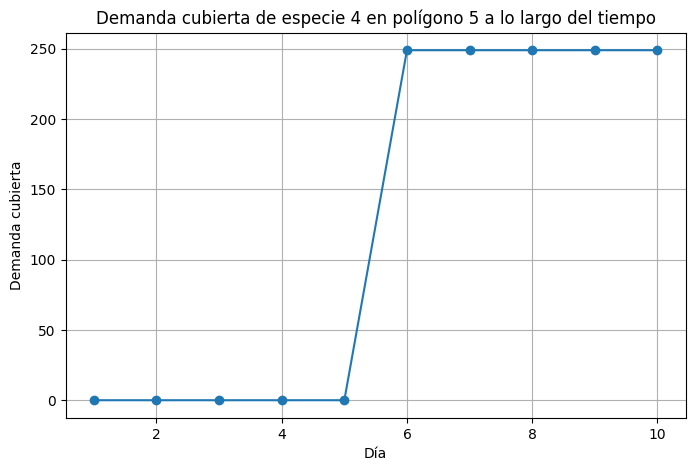

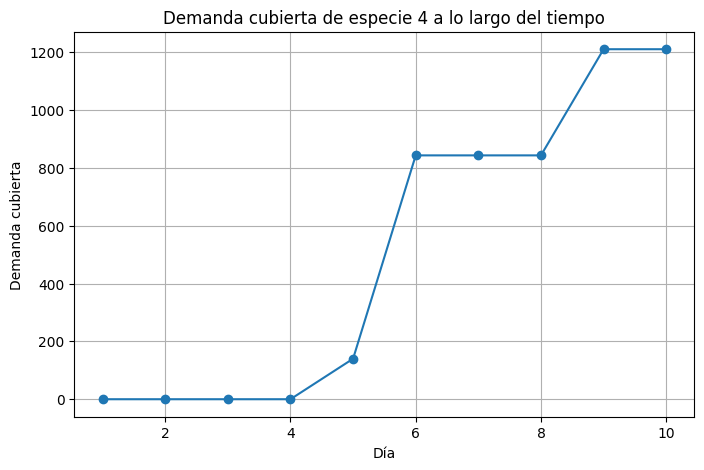

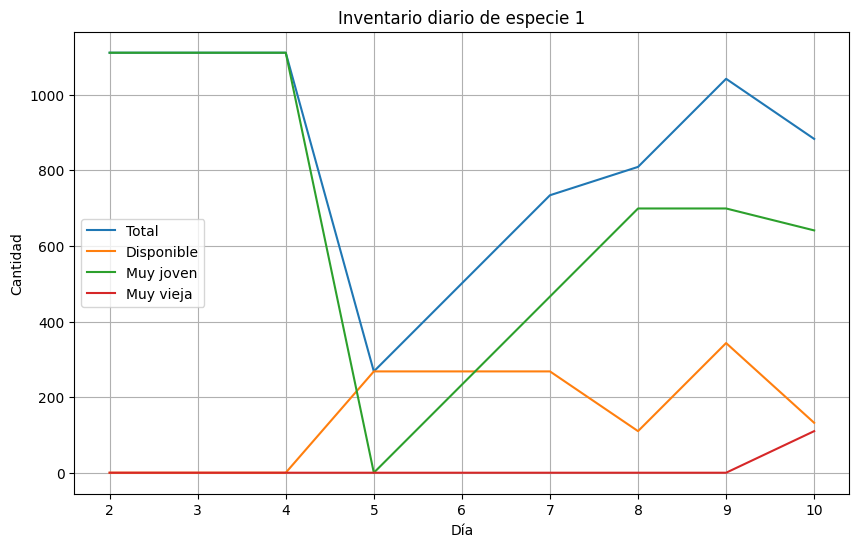

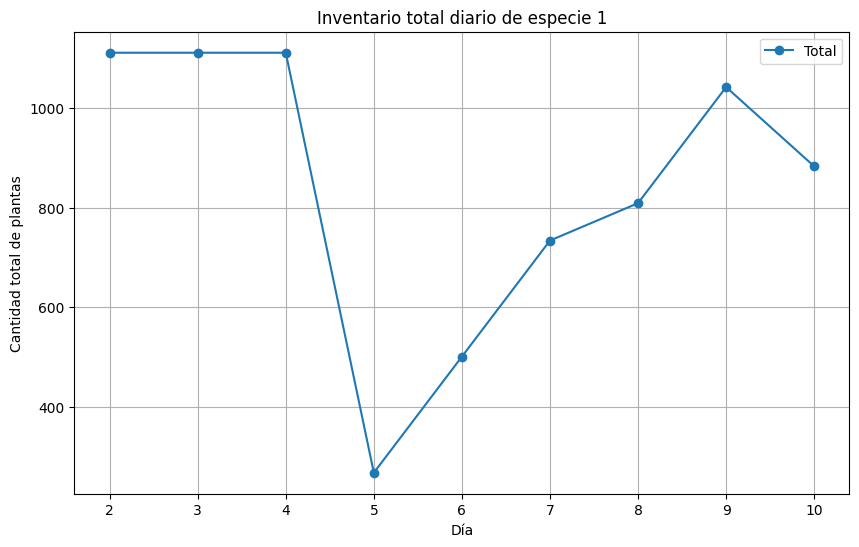

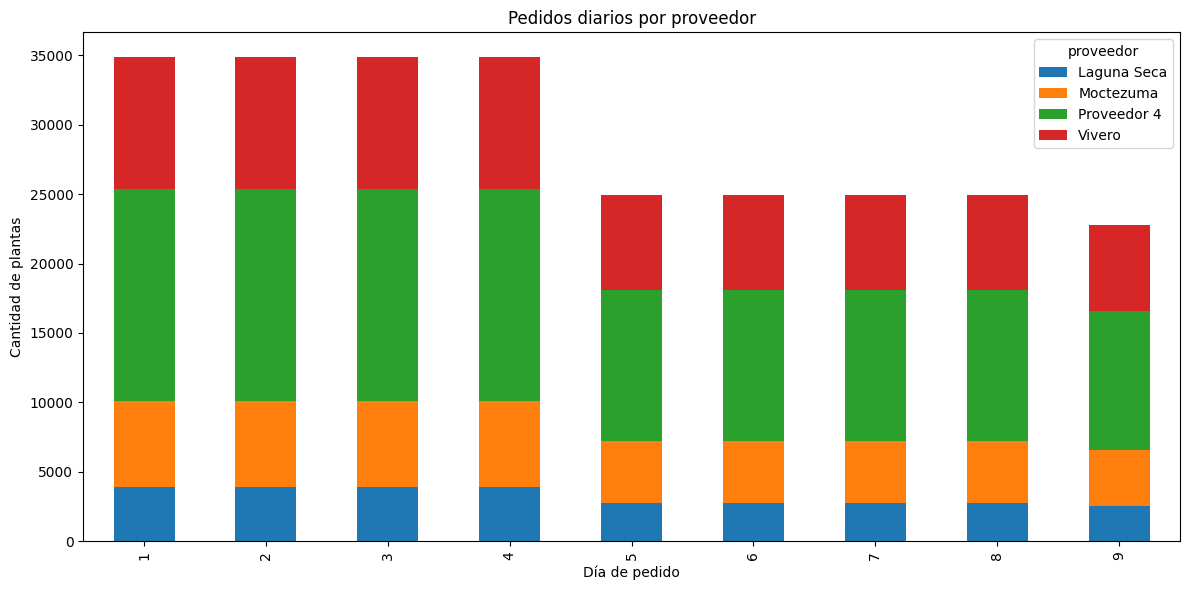

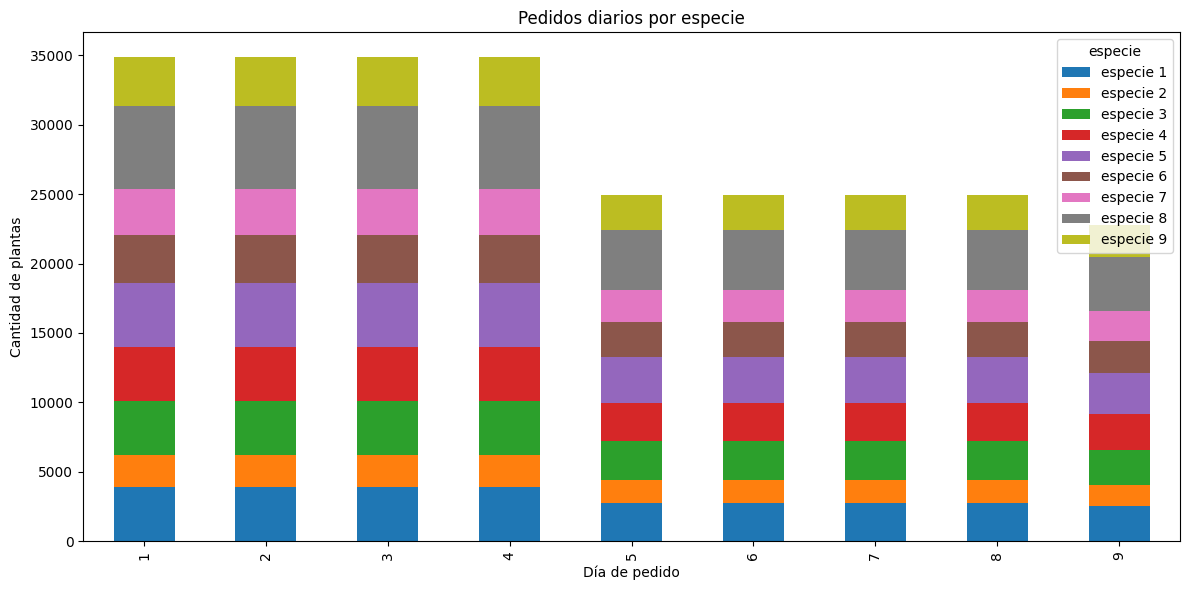

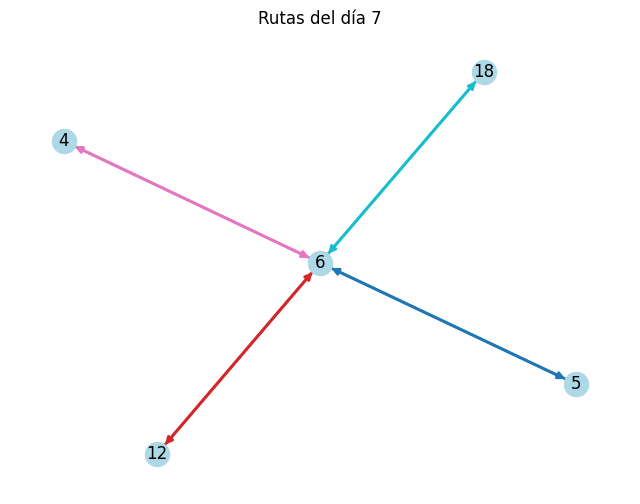

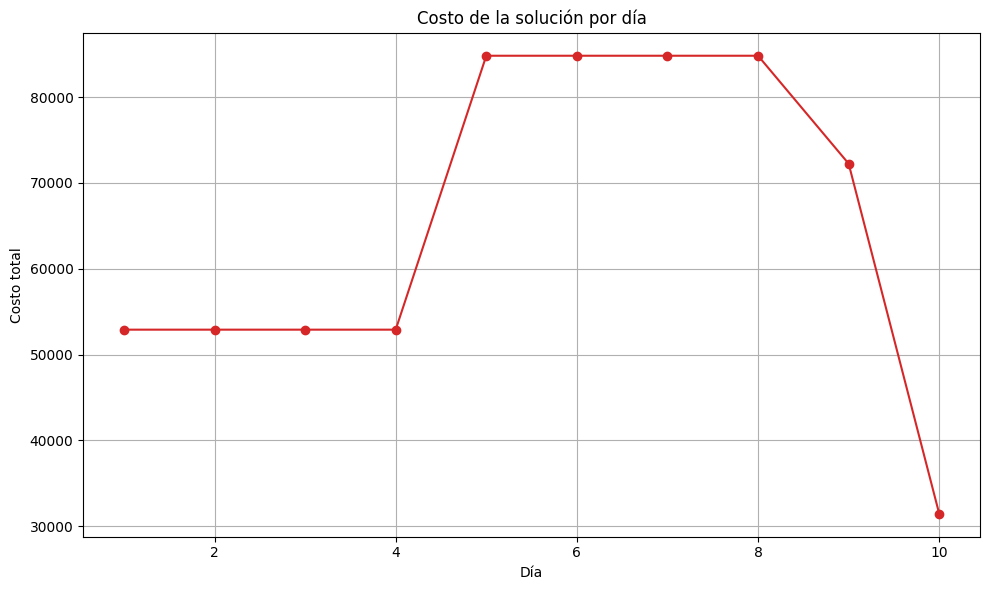

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from deap import base, creator, tools, algorithms
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import plotly.express as px
warnings.filterwarnings('ignore')

def cargar_parametros_desde_excel(ruta_excel='parametros.xlsx'):
    """
    Carga todos los parámetros desde un archivo Excel con múltiples hojas
    
    Args:
        ruta_excel: Ruta al archivo Excel con las hojas de parámetros
        
    Returns:
        params: Diccionario con todos los parámetros cargados
    """
    params = {}
    
    # 1. Cargar parámetros generales desde la hoja "parametros"
    df_params = pd.read_excel(ruta_excel, sheet_name='parametros')
    params['parametros_generales'] = {row[0]: row[1] for _, row in df_params.iterrows()}
    
    # Convertir tipos de datos según el tipo esperado
    for key in ['almacenamiento', 'costo_plantacion', 'dias_anticipacion', 
                'min_dias_aclimatacion', 'max_dias_aclimatacion', 'dias_simulacion',
                'velocidad_camioneta', 'tiempo_maximo', 'tiempo_carga', 
                'carga_maxima', 'capacidad_maxima_transporte', 'costo_transporte']:
        if key in params['parametros_generales']:
            if key in ['dias_anticipacion', 'min_dias_aclimatacion', 
                      'max_dias_aclimatacion', 'dias_simulacion']:
                params['parametros_generales'][key] = int(params['parametros_generales'][key])
            else:
                params['parametros_generales'][key] = float(params['parametros_generales'][key])
    
    # 2. Cargar hectáreas por polígono desde la hoja "hectareas_poligono"
    df_hectareas = pd.read_excel(ruta_excel, sheet_name='hectareas_poligono')
    params['hectareas_poligono'] = dict(zip(df_hectareas['poligono'], df_hectareas['hectareas']))
    
    # 3. Cargar demanda por especie desde la hoja "demanda_especies"
    df_demanda = pd.read_excel(ruta_excel, sheet_name='demanda_especies')
    params['demanda_especies_por_hectarea'] = dict(zip(df_demanda['especie'], 
                                                     df_demanda['demanda_por_hectarea']))
    
    # 4. Cargar costos de proveedores desde la hoja "costos_proveedores"
    df_costos = pd.read_excel(ruta_excel, sheet_name='costos_proveedores')
    
    # Extraer nombres de proveedores (de las columnas excluyendo la primera)
    params['nombres_proveedores'] = df_costos.columns[1:].tolist()
    
    # Extraer nombres de especies (de la primera columna)
    params['nombres_especies'] = df_costos.iloc[:, 0].tolist()
    
    # Extraer matriz de costos (convertir a float, eliminando la primera columna)
    params['matriz_costos'] = df_costos.iloc[:, 1:].values.astype(float)
    
    # 5. Cargar distancias entre polígonos desde la hoja "distancias_poligonos"
    df_distancias = pd.read_excel(ruta_excel, sheet_name='distancias_poligonos', header=None)
    params['distancias_poligonos'] = df_distancias.values
    
    return params

def obtener_parametros_simulacion(params):
    """Extrae e imprime los parámetros generales de simulación y retorna todos los valores necesarios."""
    parametros_generales = params['parametros_generales']
    almacenamiento = parametros_generales.get('almacenamiento', 400)
    espacio_por_planta = parametros_generales.get('espacio_por_planta', 0.04)
    capacidad_maxima_plantas = int(almacenamiento / espacio_por_planta)
    costo_plantacion = parametros_generales.get('costo_plantacion', 20)
    dias_anticipacion = parametros_generales.get('dias_anticipacion', 1)
    min_dias_aclimatacion = parametros_generales.get('min_dias_aclimatacion', 3)
    max_dias_aclimatacion = parametros_generales.get('max_dias_aclimatacion', 7)
    dias_simulacion = parametros_generales.get('dias_simulacion', 10)
    velocidad_camioneta = parametros_generales.get('velocidad_camioneta', 40)
    tiempo_maximo = parametros_generales.get('tiempo_maximo', 6)
    tiempo_carga = parametros_generales.get('tiempo_carga', 0.5)
    carga_maxima = parametros_generales.get('carga_maxima', 524)
    capacidad_maxima_transporte = parametros_generales.get('capacidad_maxima_transporte', 8000)
    costo_transporte = parametros_generales.get('costo_transporte', 4500)
    start_polygon = int(parametros_generales.get('start_polygon', 6))

    #Dataframe con los parámetros de simulación
    df_parametros_simulacion = pd.DataFrame([{
        "almacenamiento": almacenamiento,
        "espacio_por_planta": espacio_por_planta,
        "capacidad_maxima_plantas": capacidad_maxima_plantas,
        "costo_plantacion": costo_plantacion,
        "dias_anticipacion": dias_anticipacion,
        "min_dias_aclimatacion": min_dias_aclimatacion,
        "max_dias_aclimatacion": max_dias_aclimatacion,
        "dias_simulacion": dias_simulacion,
        "velocidad_camioneta": velocidad_camioneta,
        "tiempo_maximo": tiempo_maximo,
        "tiempo_carga": tiempo_carga,
        "carga_maxima": carga_maxima,
        "capacidad_maxima_transporte": capacidad_maxima_transporte,
        "costo_transporte": costo_transporte,
        "start_polygon": start_polygon
    }])
    # Se añade el df en los valores que retorna la función
    return (almacenamiento, espacio_por_planta, capacidad_maxima_plantas, costo_plantacion,
            dias_anticipacion, min_dias_aclimatacion, max_dias_aclimatacion, dias_simulacion,
            velocidad_camioneta, tiempo_maximo, tiempo_carga, carga_maxima,
            capacidad_maxima_transporte, costo_transporte, start_polygon, df_parametros_simulacion)

def calculate_total_demand(hectareas_poligono, demanda_especies_por_hectarea):
    """Calculate the total demand for each species across all polygons"""
    # Create dictionary to store demand per species per polygon
    polygon_species_demand = {}
    
    # Calculate demand for each polygon based on hectares and species requirements
    for polygon_id, hectares in hectareas_poligono.items():
        polygon_species_demand[polygon_id] = {}
        for species_id, demand_per_hectare in demanda_especies_por_hectarea.items():
            # Calculate demand for this species in this polygon
            polygon_species_demand[polygon_id][species_id] = round(hectares * demand_per_hectare)
    
    # Calculate total demand per species across all polygons
    total_species_demand = {species_id: 0 for species_id in demanda_especies_por_hectarea.keys()}
    for polygon_id, species_demands in polygon_species_demand.items():
        for species_id, demand in species_demands.items():
            total_species_demand[species_id] += demand
    
    return polygon_species_demand, total_species_demand

class InventoryManager:
    """Class to manage plant inventory, acclimation and orders"""
    def __init__(self, demanda_especies_por_hectarea, min_dias_aclimatacion=3, max_dias_aclimatacion=7, capacidad_maxima_plantas=None):
        self.inventory = {}  # {species_id: [(quantity, days_in_inventory), ...]}
        self.pending_orders = {}  # {delivery_day: {species_id: quantity}}
        self.current_day = 0
        self.total_ordered = {species_id: 0 for species_id in demanda_especies_por_hectarea.keys()}
        self.history = []  # Daily inventory snapshots
        self.min_dias_aclimatacion = min_dias_aclimatacion
        self.max_dias_aclimatacion = max_dias_aclimatacion
        self.capacidad_maxima_plantas = capacidad_maxima_plantas  # NUEVO: capacidad máxima de plantas
        self.inv_logs = []  # Lista para advertencias de inventario

    def place_order(self, orders, delivery_day):
        """Place orders with suppliers for delivery on specified day"""
        if delivery_day not in self.pending_orders:
            self.pending_orders[delivery_day] = {}
        
        for species_id, quantity in orders.items():
            if species_id in self.pending_orders[delivery_day]:
                self.pending_orders[delivery_day][species_id] += quantity
            else:
                self.pending_orders[delivery_day][species_id] = quantity
            
            # Track total ordered per species
            if species_id in self.total_ordered:
                self.total_ordered[species_id] += quantity
    
    def receive_deliveries(self, day):
        """Receive any deliveries scheduled for today"""
        inv_logs = []
        if day in self.pending_orders:
            total_inventario = sum(
                qty for items in self.inventory.values() for qty, _ in items
            )
            total_a_recibir = sum(self.pending_orders[day].values())
            if self.capacidad_maxima_plantas is not None and (total_inventario + total_a_recibir) > self.capacidad_maxima_plantas:
                espacio_disponible = self.capacidad_maxima_plantas - total_inventario
                if espacio_disponible <= 0:
                    self.inv_logs.append({
                        'day': day,
                        'tipo': "Inventario lleno",
                        'valor': dict(self.pending_orders[day])
                    })
                    del self.pending_orders[day]
                    return
                total_pedidos = sum(self.pending_orders[day].values())
                for species_id in list(self.pending_orders[day].keys()):
                    cantidad_original = self.pending_orders[day][species_id]
                    cantidad_ajustada = int(round(cantidad_original * espacio_disponible / total_pedidos))
                    self.pending_orders[day][species_id] = max(0, cantidad_ajustada)
                self.inv_logs.append({
                    'day': day,
                    'tipo': "Ajuste de entregas",
                    'valor': dict(self.pending_orders[day])
                })
            for species_id, quantity in self.pending_orders[day].items():
                if quantity <= 0:
                    continue
                if species_id not in self.inventory:
                    self.inventory[species_id] = []
                # Add to inventory with 0 days acclimation
                self.inventory[species_id].append((quantity, 0))
            # Clear processed orders
            del self.pending_orders[day]
    
    def update_inventory(self):
        """Age inventory by one day and take daily snapshot"""
        # Take snapshot before updating
        snapshot = self._get_inventory_snapshot()
        self.history.append(snapshot)
        
        # Update age of all plants
        for species_id in self.inventory:
            self.inventory[species_id] = [(qty, days + 1) for qty, days in self.inventory[species_id]]
    
    def _get_inventory_snapshot(self):
        """Create a snapshot of current inventory state"""
        snapshot = {
            'total': {},
            'available': {},
            'by_age': {}
        }
        
        for species_id, items in self.inventory.items():
            # Total quantity by species
            total_qty = sum(qty for qty, _ in items)
            snapshot['total'][species_id] = total_qty
            
            # Available quantity (3-7 days)
            avail_qty = sum(qty for qty, days in items if self.min_dias_aclimatacion <= days <= self.max_dias_aclimatacion)
            snapshot['available'][species_id] = avail_qty
            
            # Group by days
            by_age = {}
            for qty, days in items:
                if days not in by_age:
                    by_age[days] = 0
                by_age[days] += qty
            snapshot['by_age'][species_id] = by_age
            
        return snapshot
    
    def get_available_inventory(self):
        """Get inventory items available for transport (3-7 days old)"""
        available = {}
        for species_id, items in self.inventory.items():
            available_qty = sum(qty for qty, days in items if self.min_dias_aclimatacion <= days <= self.max_dias_aclimatacion)
            if available_qty > 0:
                available[species_id] = available_qty
        return available
    
    def get_inventory_summary(self):
        """Get a summary of current inventory"""
        summary = {}
        for species_id, items in self.inventory.items():
            total = sum(qty for qty, _ in items)
            available = sum(qty for qty, days in items if self.min_dias_aclimatacion <= days <= self.max_dias_aclimatacion)
            too_young = sum(qty for qty, days in items if days < self.min_dias_aclimatacion)
            too_old = sum(qty for qty, days in items if days > self.max_dias_aclimatacion)
            
            summary[species_id] = {
                'total': total,
                'available': available,
                'too_young': too_young,
                'too_old': too_old
            }
        return summary
    
    def remove_from_inventory(self, species_distribution):
        """Remove distributed items from inventory, prioritizing oldest items"""
        for species_id, qty_needed in species_distribution.items():
            if species_id not in self.inventory or qty_needed <= 0:
                continue
                
            # Sort by age (oldest first)
            self.inventory[species_id].sort(key=lambda x: x[1], reverse=True)
            
            qty_remaining = qty_needed
            new_inventory = []
            
            for qty, days in self.inventory[species_id]:
                if self.min_dias_aclimatacion <= days <= self.max_dias_aclimatacion and qty_remaining > 0:
                    # This batch is available for distribution
                    if qty <= qty_remaining:
                        # Use entire batch
                        qty_remaining -= qty
                    else:
                        # Use part of batch
                        new_inventory.append((qty - qty_remaining, days))
                        qty_remaining = 0
                else:
                    # Either not available or no more needed
                    new_inventory.append((qty, days))
            
            self.inventory[species_id] = new_inventory

def calculate_route_time(route, dist_poligonos_hrs):
    if len(route) <= 1:
        return 0
    
    total_time = 0
    # Sumar los tiempos de viaje entre polígonos consecutivos
    for i in range(len(route) - 1):
        total_time += dist_poligonos_hrs[route[i], route[i+1]]
    
    # Añadir tiempos de carga/descarga (0.5 hrs por polígono visitado) más 0.5 extra
    # Se resta 2 porque no contamos como paradas el polígono inicial y final si son el mismo
    total_time += 0.5 * (len(route) - 2) + 0.5
    
    return total_time

def generar_rutas_largas(
    current_demand, 
    available_inventory, 
    dist_poligonos_hrs, 
    START_POLYGON, 
    tiempo_maximo, 
    carga_maxima
):
    """
    Genera rutas largas: cada ruta intenta visitar el mayor número posible de polígonos,
    repartiendo plantas hasta agotar la carga máxima y el tiempo permitido.
    """
    NUM_POLYGONS = dist_poligonos_hrs.shape[0]
    poligonos_restantes = [i for i in range(NUM_POLYGONS) if i != START_POLYGON and i in current_demand]
    rutas = []

    while poligonos_restantes:
        ruta = [START_POLYGON]
        carga_restante = carga_maxima
        tiempo_total = 0
        entrega_total = 0
        inventario_tmp = available_inventory.copy()
        poligonos_visitados = []

        # Intentar agregar el mayor número de polígonos posible a la ruta
        for poligono in poligonos_restantes:
            ruta_provisional = ruta + [poligono] + [START_POLYGON]
            tiempo_provisional = calculate_route_time(ruta_provisional, dist_poligonos_hrs)
            if tiempo_provisional > tiempo_maximo:
                continue

            # Calcular cuántas plantas se pueden entregar en este polígono
            entrega_poligono = 0
            carga_tmp = carga_restante
            for especie, demanda in current_demand[poligono].items():
                disponible = inventario_tmp.get(especie, 0)
                a_entregar = min(demanda, disponible, carga_tmp)
                entrega_poligono += a_entregar
                carga_tmp -= a_entregar
                if carga_tmp <= 0:
                    break

            if entrega_poligono > 0:
                ruta.append(poligono)
                poligonos_visitados.append(poligono)
                carga_restante -= entrega_poligono
                entrega_total += entrega_poligono
                tiempo_total = calculate_route_time(ruta + [START_POLYGON], dist_poligonos_hrs)
                # Actualizar inventario temporal
                for especie, demanda in current_demand[poligono].items():
                    disponible = inventario_tmp.get(especie, 0)
                    a_entregar = min(demanda, disponible, carga_maxima)
                    inventario_tmp[especie] = max(0, disponible - a_entregar)
                if carga_restante <= 0:
                    break

        if len(ruta) == 1 or entrega_total == 0:
            # No se pudo agregar ningún polígono útil
            break

        ruta_final = ruta + [START_POLYGON]
        rutas.append((ruta_final, tiempo_total, entrega_total))

        # Eliminar los polígonos ya visitados
        for poligono in poligonos_visitados:
            if poligono in poligonos_restantes:
                poligonos_restantes.remove(poligono)
        # Actualizar inventario real
        for especie in available_inventory:
            available_inventory[especie] = inventario_tmp.get(especie, available_inventory[especie])

    return rutas

def generar_mejores_rutas_greedy(
    current_demand, 
    available_inventory, 
    dist_poligonos_hrs, 
    START_POLYGON, 
    tiempo_maximo, 
    carga_maxima, 
    max_poligonos=10
):
    """
    Genera rutas greedy priorizando la máxima entrega de plantas (todas las especies)
    y usando el tiempo de ruta como criterio secundario.
    """
    NUM_POLYGONS = dist_poligonos_hrs.shape[0]
    poligonos_restantes = [i for i in range(NUM_POLYGONS) if i != START_POLYGON and i in current_demand]
    rutas = []

    while poligonos_restantes:
        mejor_ruta = None
        mejor_entrega = 0
        mejor_tiempo = None

        # Probar rutas cortas de 1 hasta max_poligonos
        for tam in range(1, min(max_poligonos, len(poligonos_restantes)) + 1):
            # Probar todas las combinaciones posibles de tamaño tam (puedes optimizar usando heurística)
            for seleccion in [poligonos_restantes[i:i+tam] for i in range(len(poligonos_restantes)-tam+1)]:
                ruta = [START_POLYGON] + seleccion + [START_POLYGON]
                tiempo = calculate_route_time(ruta, dist_poligonos_hrs)
                if tiempo > tiempo_maximo:
                    continue

                # Calcular cuántas plantas se podrían entregar en esta ruta
                entrega_total = 0
                carga_restante = carga_maxima
                for poligono in seleccion:
                    if poligono not in current_demand:
                        continue
                    for especie, demanda in current_demand[poligono].items():
                        disponible = available_inventory.get(especie, 0)
                        a_entregar = min(demanda, disponible, carga_restante)
                        entrega_total += a_entregar
                        carga_restante -= a_entregar
                        if carga_restante <= 0:
                            break
                    if carga_restante <= 0:
                        break

                # Guardar la mejor ruta (más entrega, menor tiempo)
                if entrega_total > mejor_entrega or (entrega_total == mejor_entrega and (mejor_tiempo is None or tiempo < mejor_tiempo)):
                    mejor_ruta = ruta
                    mejor_entrega = entrega_total
                    mejor_tiempo = tiempo

        if mejor_ruta is None or mejor_entrega == 0:
            # No se puede hacer más rutas útiles
            break

        rutas.append((mejor_ruta, mejor_tiempo, mejor_entrega))

        # Marcar polígonos visitados como atendidos (puedes ajustar según si quieres permitir visitas múltiples)
        for poligono in mejor_ruta[1:-1]:
            if poligono in poligonos_restantes:
                poligonos_restantes.remove(poligono)

    return rutas

def calcular_max_plantas_repartibles(tiempo_maximo, tiempo_carga, carga_maxima, min_dias_aclimatacion, max_dias_aclimatacion):
    """
    Calcula el máximo de plantas que se pueden repartir en el rango de días útiles.
    """
    # Suponiendo viajes cortos: tiempo mínimo por viaje = tiempo_carga*2 (salida y regreso)
    tiempo_min_viaje = tiempo_carga * 2
    max_viajes_dia = int(tiempo_maximo // tiempo_min_viaje)
    dias_utiles = max_dias_aclimatacion - min_dias_aclimatacion + 1
    return max_viajes_dia * carga_maxima * dias_utiles

def plantas_en_rango_util(inventory, species_id, day, min_dias_aclimatacion, max_dias_aclimatacion):
    # Plantas en inventario que estarán en rango útil en los próximos días
    en_rango = sum(
        qty for qty, days in inventory.inventory.get(species_id, [])
        if min_dias_aclimatacion <= days <= max_dias_aclimatacion
    )
    # Pedidos en tránsito que llegarán en el rango útil
    en_transito = 0
    for entrega_dia, pedidos in inventory.pending_orders.items():
        dias_hasta_entrega = entrega_dia - day
        if 0 <= dias_hasta_entrega <= (max_dias_aclimatacion - min_dias_aclimatacion):
            en_transito += pedidos.get(species_id, 0)
    return en_rango + en_transito

def place_orders_with_suppliers(
    inventory, remaining_demand, matriz_costos, costo_transporte, 
    capacidad_maxima_transporte, day, delivery_day, 
    nombres_especies, nombres_proveedores,
    dias_anticipacion=1, min_dias_aclimatacion=3, max_dias_aclimatacion=7, 
    tiempo_maximo=6, tiempo_carga=0.5, carga_maxima=524, current_demand=None
):
    """
    Heurística: Solo pedir lo que se puede repartir en el rango de días útiles.
    """
    max_plantas_rango = calcular_max_plantas_repartibles(
        tiempo_maximo, tiempo_carga, carga_maxima, min_dias_aclimatacion, max_dias_aclimatacion
    )

    # Calcular demanda futura en el rango de días útiles
    demanda_futura = {}
    if current_demand is not None:
        for species_id in remaining_demand:
            demanda_futura[species_id] = 0
        for polygon, species_demands in current_demand.items():
            for species_id, qty in species_demands.items():
                if species_id in demanda_futura:
                    demanda_futura[species_id] += qty
    else:
        demanda_futura = remaining_demand.copy()

    # Limitar pedido por especie al máximo que se puede repartir en el rango
    orders_by_species = {}
    total_cost = 0
    total_ordered = 0
    pedidos_rows = []

    for species_id, demand in demanda_futura.items():
        # Plantas que estarán disponibles en el rango útil (inventario + pedidos en tránsito)
        total_en_rango = plantas_en_rango_util(
            inventory, species_id, day, min_dias_aclimatacion, max_dias_aclimatacion
        )
        pedido = max(0, min(demand, max_plantas_rango) - total_en_rango)
        if pedido <= 0:
            continue
        species_index = int(species_id) - 1
        if species_index < 0 or species_index >= len(matriz_costos):
            #print(f"Error: Species ID {species_id} out of range in cost matrix")
            continue
        provider_costs = matriz_costos[species_index]
        min_cost_idx = np.argmin(provider_costs)
        min_cost = provider_costs[min_cost_idx]
        if species_id not in orders_by_species:
            orders_by_species[species_id] = {}
        provider_id = min_cost_idx + 1
        orders_by_species[species_id][provider_id] = pedido
        # Registrar pedido para DataFrame
        especie = nombres_especies[species_index] if species_index < len(nombres_especies) else f"Especie {species_id}"
        proveedor = nombres_proveedores[min_cost_idx] if min_cost_idx < len(nombres_proveedores) else f"Proveedor {provider_id}"
        pedidos_rows.append({
            "dia_pedido": day + 1,
            "dia_entrega": delivery_day + 1,
            "especie": especie,
            "proveedor": proveedor,
            "cantidad": pedido
        })
        total_cost += pedido * min_cost + costo_transporte
        total_ordered += pedido

    # Registrar pedidos en el inventario
    for species_id, providers in orders_by_species.items():
        total_qty = sum(providers.values())
        inventory.place_order({species_id: total_qty}, delivery_day)

    return orders_by_species, pedidos_rows

def distribute_plants_to_routes(inventory, current_demand, routes, carga_maxima):
    """
    Distribuye plantas priorizando especies con más plantas próximas a volverse viejas.
    """
    available_inventory = inventory.get_available_inventory()
    if not available_inventory:
        inventory.inv_logs.append({
            'day': inventory.current_day + 1,
            'tipo': "Inventario vacío",
            'valor': dict(available_inventory)
        })
        return {}, {}

    # 1. Calcular cuántas plantas están próximas a ser viejas por especie
    species_oldness = {}
    for species_id, items in inventory.inventory.items():
        # Prioriza plantas con días = max_dias_aclimatacion-2 o mayores (pero >= min)
        count = sum(qty for qty, days in items if days >= max(inventory.max_dias_aclimatacion - 2, inventory.min_dias_aclimatacion))
        species_oldness[species_id] = count

    # 2. Ordenar especies por mayor cantidad de plantas próximas a ser viejas
    sorted_species = sorted(
        available_inventory.keys(),
        key=lambda s: species_oldness.get(s, 0),
        reverse=True
    )

    distribution_plan = {}
    route_loads = {}

    for route_idx in range(len(routes)):
        distribution_plan[route_idx] = {}
        route_loads[route_idx] = 0
        route_path = routes[route_idx][0]
        for polygon in route_path[1:-1]:
            if polygon in current_demand:
                distribution_plan[route_idx][polygon] = {}
                # Usar el orden priorizado de especies
                for species_id in sorted_species:
                    demand = current_demand[polygon].get(species_id, 0)
                    if demand > 0 and species_id in available_inventory:
                        available = available_inventory[species_id]
                        to_deliver = min(demand, available, carga_maxima - route_loads[route_idx])
                        if to_deliver > 0:
                            distribution_plan[route_idx][polygon][species_id] = to_deliver
                            available_inventory[species_id] -= to_deliver
                            route_loads[route_idx] += to_deliver
                            if available_inventory[species_id] <= 0:
                                del available_inventory[species_id]

    # Remove plants from inventory
    total_distribution = {}
    for route_idx, polygon_dist in distribution_plan.items():
        for polygon, species_dist in polygon_dist.items():
            for species_id, qty in species_dist.items():
                if species_id not in total_distribution:
                    total_distribution[species_id] = 0
                total_distribution[species_id] += qty

    inventory.remove_from_inventory(total_distribution)
    return distribution_plan, route_loads

def update_demand_after_distribution(current_demand, distribution_plan):
    """Update remaining demand after plants have been distributed"""
    updated_demand = {}
    
    # Make a deep copy of current demand
    for polygon, species_demands in current_demand.items():
        updated_demand[polygon] = {species: qty for species, qty in species_demands.items()}
    
    # Subtract distributed plants
    for route_idx, polygon_dist in distribution_plan.items():
        for polygon, species_dist in polygon_dist.items():
            if polygon in updated_demand:
                for species_id, qty in species_dist.items():
                    if species_id in updated_demand[polygon]:
                        updated_demand[polygon][species_id] -= qty
                        # Ensure non-negative demand
                        updated_demand[polygon][species_id] = max(0, updated_demand[polygon][species_id])
    
    return updated_demand

def calculate_demand_coverage(total_species_demand, current_demand):
    """Calculate percentage of demand that has been covered"""
    coverage = {}
    
    # Calculate remaining total demand by species
    remaining_demand = {species_id: 0 for species_id in total_species_demand.keys()}
    for polygon, species_demands in current_demand.items():
        for species_id, qty in species_demands.items():
            if species_id in remaining_demand:
                remaining_demand[species_id] += qty
    
    # Calculate coverage percentage
    for species_id, total in total_species_demand.items():
        if total > 0:
            coverage[species_id] = 1.0 - (remaining_demand[species_id] / total)
        else:
            coverage[species_id] = 1.0  # No demand means 100% coverage
    
    return coverage

def generar_reporte_diario_df(day, inventory, current_demand, nombres_especies, polygon_species_demand):
    """
    Genera registros del inventario y demanda diaria por especie y polígono para el día actual.
    En df_cobertura_demanda ahora se muestra la demanda cubierta.
    """
    inv_summary = inventory.get_inventory_summary()
    inventario_rows = []
    for species_id, info in inv_summary.items():
        species_idx = int(species_id) - 1
        species_name = nombres_especies[species_idx] if species_idx < len(nombres_especies) else f"Especie {species_id}"
        inventario_rows.append({
            "dia": day + 1,
            "especie": species_name,
            "total": info['total'],
            "disponible": info['available'],
            "muy_joven": info['too_young'],
            "muy_vieja": info['too_old']
        })
    # Demanda cubierta por polígono y especie
    cobertura_rows = []
    for poligono, species_demands in current_demand.items():
        for species_id, demanda_restante in species_demands.items():
            species_idx = int(species_id) - 1
            species_name = nombres_especies[species_idx] if species_idx < len(nombres_especies) else f"Especie {species_id}"
            demanda_inicial = polygon_species_demand[poligono][species_id]
            demanda_cubierta = demanda_inicial - demanda_restante
            cobertura_rows.append({
                "dia": day + 1,
                "poligono": poligono,
                "especie": species_name,
                "demanda_cubierta": demanda_cubierta
            })
    return inventario_rows, cobertura_rows

def registrar_pedidos_df(day, delivery_day, orders_by_species, nombres_especies, nombres_proveedores):
    """Convierte los pedidos realizados en registros para el DataFrame de pedidos."""
    pedidos_rows = []
    for species_id, providers in orders_by_species.items():
        species_idx = int(species_id) - 1
        especie = nombres_especies[species_idx] if species_idx < len(nombres_especies) else f"Especie {species_id}"
        for provider_id, cantidad in providers.items():
            proveedor = nombres_proveedores[provider_id - 1] if provider_id - 1 < len(nombres_proveedores) else f"Proveedor {provider_id}"
            pedidos_rows.append({
                "dia_pedido": day + 1,
                "dia_entrega": delivery_day + 1,
                "especie": especie,
                "proveedor": proveedor,
                "cantidad": cantidad
            })
    return pedidos_rows

def registrar_distribucion_df(day, distribution_plan, nombres_especies):
    """Convierte el plan de distribución en registros para el DataFrame de distribución."""
    distribucion_rows = []
    for route_idx, polygon_dist in distribution_plan.items():
        for polygon, species_dist in polygon_dist.items():
            for species_id, qty in species_dist.items():
                species_idx = int(species_id) - 1
                especie = nombres_especies[species_idx] if species_idx < len(nombres_especies) else f"Especie {species_id}"
                distribucion_rows.append({
                    "dia": day + 1,
                    "ruta": route_idx + 1,
                    "poligono": polygon,
                    "especie": especie,
                    "cantidad": qty
                })
    return distribucion_rows

def registrar_rutas_df(day, today_route):
    """Convierte las rutas del día en registros para el DataFrame de rutas."""
    rutas_rows = []
    for idx, (ruta, tiempo, entrega) in enumerate(today_route):
        rutas_rows.append({
            "dia": day + 1,
            "ruta": idx + 1,
            "poligonos": ruta,
            "tiempo": tiempo,
            "entrega_total": entrega
        })
    return rutas_rows

def calcular_costos_solucion_por_dia(
    day,
    pedidos_dia,
    distribucion_rows_dia,
    costo_plantacion,
    costo_transporte,
    nombres_proveedores
):
    """
    Calcula el costo de la solución para un día:
    - Costo de adquisición por proveedor
    - Costo de transporte (por proveedor elegido)
    - Costo de plantación (por plantas distribuidas)
    - Costo total de proveedores (suma de todas las adquisiciones)
    - Total = costo_transporte + plantacion + costo_proveedores
    """
    df_pedidos_dia = pd.DataFrame(pedidos_dia)
    costos_proveedores = {}
    proveedores_usados = set()
    if not df_pedidos_dia.empty:
        for proveedor in nombres_proveedores:
            total = df_pedidos_dia[df_pedidos_dia['proveedor'] == proveedor]['cantidad'].sum()
            if total > 0:
                costos_proveedores[proveedor] = total
                proveedores_usados.add(proveedor)
    else:
        for proveedor in nombres_proveedores:
            costos_proveedores[proveedor] = 0

    # Costo de transporte
    costo_transporte_total = costo_transporte * len(proveedores_usados)

    # Costo de plantación
    df_distribucion_dia = pd.DataFrame(distribucion_rows_dia)
    plantas_plantadas = df_distribucion_dia['cantidad'].sum() if not df_distribucion_dia.empty else 0
    costo_plantacion_total = plantas_plantadas * costo_plantacion

    # Costo de adquisición total (suma de todas las adquisiciones a proveedores)
    costo_proveedores_total = sum(costos_proveedores.values())

    # Total
    total = costo_transporte_total + costo_plantacion_total + costo_proveedores_total

    # Estructura para DataFrame
    row = {
        "dia": day + 1,
        "costo_transporte": costo_transporte_total,
        "plantacion": costo_plantacion_total,
        "costo_proveedores": costo_proveedores_total,
        "total": total
    }
    # Agregar columnas por proveedor (cantidad de plantas pedidas)
    for proveedor in nombres_proveedores:
        row[f"adquisicion_{proveedor}"] = costos_proveedores.get(proveedor, 0)
    return row

def run_simulation(
    dias_simulacion, dias_anticipacion, min_dias_aclimatacion, max_dias_aclimatacion,
    hectareas_poligono, demanda_especies_por_hectarea, capacidad_maxima_transporte,
    costo_transporte, carga_maxima, nombres_especies, nombres_proveedores, 
    matriz_costos, dist_poligonos_hrs, NUM_POLYGONS, START_POLYGON, tiempo_maximo,
    capacidad_maxima_plantas, tiempo_carga, costo_plantacion,
    tipo_ruta="greedy"
):
    # Calculate initial demands
    polygon_species_demand, total_species_demand = calculate_total_demand(
        hectareas_poligono=hectareas_poligono, 
        demanda_especies_por_hectarea=demanda_especies_por_hectarea
    )
    
    # Convert total demand to list format for reporting
    initial_demand_list = [total_species_demand.get(i, 0) for i in range(1, len(nombres_especies) + 1)]
    
    # Create inventory manager
    inventory = InventoryManager(
        demanda_especies_por_hectarea,
        min_dias_aclimatacion=min_dias_aclimatacion,
        max_dias_aclimatacion=max_dias_aclimatacion,
        capacidad_maxima_plantas=capacidad_maxima_plantas
    )
    
    # Daily tracking of orders, routes, and demand fulfillment
    daily_orders = {}
    daily_routes = {}
    daily_distributions = {}
    daily_demand_coverage = []
    
    # Deep copy of initial demand for tracking
    current_demand = {polygon: {species: qty for species, qty in species_demand.items()} 
                    for polygon, species_demand in polygon_species_demand.items()}
    
    # Inicializar listas para los DataFrames
    inventario_diario_rows = []
    cobertura_demanda_rows = []
    pedidos_rows = []
    distribucion_rows = []
    rutas_rows = []
    inv_warnings_rows = []
    costos_solucion_rows = []
    
    for day in range(dias_simulacion):
        # 1. Receive any pending deliveries
        inventory.receive_deliveries(day)

        # 2. Verificar si hay plantas disponibles para repartir
        available_inventory = inventory.get_available_inventory()
        hay_plantas = any(qty > 0 for qty in available_inventory.values())

        pedidos_dia = []
        distribucion_rows_dia = []
        if hay_plantas:
            # Selección de función de rutas según tipo_ruta
            if tipo_ruta == "larga":
                rutas_func = generar_rutas_largas
            else:
                rutas_func = generar_mejores_rutas_greedy
            all_routes = rutas_func(
                current_demand, available_inventory, dist_poligonos_hrs,
                START_POLYGON, tiempo_maximo, carga_maxima
            )
            if all_routes:
                rutas_del_dia = []
                tiempo_acumulado = 0
                for ruta, tiempo, _ in all_routes:
                    if tiempo_acumulado + tiempo <= tiempo_maximo:
                        rutas_del_dia.append((ruta, tiempo, _))
                        tiempo_acumulado += tiempo
                    else:
                        break
                today_route = rutas_del_dia
                daily_routes[day] = today_route

                # 4. Distribuir plantas en todas las rutas generadas hoy
                distribution_plan, route_loads = distribute_plants_to_routes(
                    inventory, current_demand, today_route, carga_maxima
                )
                daily_distributions[day] = distribution_plan
                distribucion_rows_dia = registrar_distribucion_df(day, distribution_plan, nombres_especies)

                # 5. Actualizar demanda restante
                current_demand = update_demand_after_distribution(
                    current_demand, distribution_plan
                )
            else:
                today_route = []
                daily_routes[day] = today_route
                distribution_plan = {}
                route_loads = {}
                distribucion_rows_dia = []
        else:
            today_route = []
            daily_routes[day] = today_route
            distribution_plan = {}
            route_loads = {}
            distribucion_rows_dia = []
        # 6. Calculate demand coverage
        coverage = calculate_demand_coverage(total_species_demand, current_demand)
        daily_demand_coverage.append(coverage)

        # 7. Order plants for future delivery (estrategia para minimizar plantas viejas)
        current_orders = None
        pedidos_dia = []
        if day < dias_simulacion - dias_anticipacion:
            delivery_day = day + dias_anticipacion
            # Calcular demanda restante
            remaining_demand = {}
            for polygon, species_demands in current_demand.items():
                for species_id, demand in species_demands.items():
                    if demand > 0:
                        if species_id in remaining_demand:
                            remaining_demand[species_id] += demand
                        else:
                            remaining_demand[species_id] = demand
            # Pedir solo lo necesario para cubrir demanda futura y no sobrepedir
            if remaining_demand:
                current_orders, pedidos_dia = place_orders_with_suppliers(
                    inventory, remaining_demand, matriz_costos, costo_transporte, 
                    capacidad_maxima_transporte, day, delivery_day, 
                    nombres_especies, nombres_proveedores,
                    dias_anticipacion=dias_anticipacion,
                    min_dias_aclimatacion=min_dias_aclimatacion,
                    max_dias_aclimatacion=max_dias_aclimatacion,
                    tiempo_maximo=tiempo_maximo,
                    tiempo_carga=tiempo_carga,
                    carga_maxima=carga_maxima,
                    current_demand=current_demand
                )
                daily_orders[day] = (delivery_day, current_orders)
        # Registro de DataFrames diarios
        inv_rows, cov_rows = generar_reporte_diario_df(
            day, inventory, current_demand, nombres_especies, polygon_species_demand
        )
        inventario_diario_rows.extend(inv_rows)
        cobertura_demanda_rows.extend(cov_rows)
        if pedidos_dia:
            pedidos_rows.extend(pedidos_dia)
        distribucion_rows.extend(distribucion_rows_dia)
        rutas_rows.extend(registrar_rutas_df(day, today_route))
        # Calcular costos de la solución para el día
        row_costos = calcular_costos_solucion_por_dia(
            day,
            pedidos_dia,
            distribucion_rows_dia,
            costo_plantacion,
            costo_transporte,
            nombres_proveedores
        )
        costos_solucion_rows.append(row_costos)
        # 9. Update inventory ages
        inventory.update_inventory()

        # Actualizar el día actual en InventoryManager para advertencias
        inventory.current_day = day
        if hasattr(inventory, "inv_logs") and inventory.inv_logs:
            inv_warnings_rows.extend(inventory.inv_logs)
            inventory.inv_logs = []

    # Convertir listas a DataFrames
    df_inventario_diario = pd.DataFrame(inventario_diario_rows)
    df_cobertura_demanda = pd.DataFrame(cobertura_demanda_rows)
    df_pedidos = pd.DataFrame(pedidos_rows)
    df_distribucion = pd.DataFrame(distribucion_rows)
    df_rutas = pd.DataFrame(rutas_rows)
    df_inv_warnings = pd.DataFrame(inv_warnings_rows)
    df_costos_solucion = pd.DataFrame(costos_solucion_rows)
    
    # Return simulation data
    return {
        "df_inventario_diario": df_inventario_diario,
        "df_cobertura_demanda": df_cobertura_demanda,
        "df_pedidos": df_pedidos,
        "df_distribucion": df_distribucion,
        "df_rutas": df_rutas,
        "df_inv_warnings": df_inv_warnings,
        "df_costos_solucion": df_costos_solucion,
        "daily_orders": daily_orders,
        "daily_routes": daily_routes,
        "daily_distributions": daily_distributions,
        "daily_demand_coverage": daily_demand_coverage,
        "final_demand": current_demand,
        "inventory_history": inventory.history
    }
# Obtener dataframes:
def get_simulation_dataframes(simulation_result):
    """
    Extrae los DataFrames de resultados de la simulación.
    """
    return (
        simulation_result['df_inventario_diario'],
        simulation_result['df_cobertura_demanda'],
        simulation_result['df_pedidos'],
        simulation_result['df_distribucion'],
        simulation_result['df_rutas'],
        simulation_result['df_inv_warnings'],
        simulation_result['df_costos_solucion']
    )
#  VISUALIZACIONES
#-----------------------------------------------
# DEMANDA
def plot_demanda_cubierta_por_especie_poligono(df_cobertura_demanda, especie, poligono = None):
    """
    Grafica la demanda cubierta de una especie en un polígono específico a lo largo del tiempo.
    Si poligono es None, grafica la demanda cubierta de la especie en todos los polígonos.
    Devuelve la figura matplotlib.
    """
    if poligono:
        df = df_cobertura_demanda[
            (df_cobertura_demanda['especie'] == especie) &
            (df_cobertura_demanda['poligono'] == poligono)
        ]
        fig, ax = plt.subplots(figsize=(8,5))
        ax.plot(df['dia'], df['demanda_cubierta'], marker='o')
        ax.set_title(f'Demanda cubierta de {especie} en polígono {poligono} a lo largo del tiempo')
        ax.set_xlabel('Día')
        ax.set_ylabel('Demanda cubierta')
        ax.grid(True)
        return fig
    else:
        df = df_cobertura_demanda[df_cobertura_demanda['especie'] == especie]
        resumen = df.groupby('dia')['demanda_cubierta'].sum().reset_index()
        fig, ax = plt.subplots(figsize=(8,5))
        ax.plot(resumen['dia'], resumen['demanda_cubierta'], marker='o')
        ax.set_title(f'Demanda cubierta de {especie} a lo largo del tiempo')
        ax.set_xlabel('Día')
        ax.set_ylabel('Demanda cubierta')
        ax.grid(True)
        return fig

def plot_inventario_diario(df_inventario_diario, especie=None):
    """
    Grafica el inventario total, disponible, muy joven y muy vieja por especie a lo largo del tiempo.
    Si especie es None, grafica todas las especies en subplots. 
    Devuelve la figura matplotlib.
    """
    if especie:
        df = df_inventario_diario[df_inventario_diario['especie'] == especie]
        fig, ax = plt.subplots(figsize=(10,6))
        ax.plot(df['dia'], df['total'], label='Total')
        ax.plot(df['dia'], df['disponible'], label='Disponible')
        ax.plot(df['dia'], df['muy_joven'], label='Muy joven')
        ax.plot(df['dia'], df['muy_vieja'], label='Muy vieja')
        ax.set_title(f'Inventario diario de {especie}')
        ax.set_xlabel('Día')
        ax.set_ylabel('Cantidad')
        ax.legend()
        ax.grid(True)
        return fig
    else:
        especies = df_inventario_diario['especie'].unique()
        fig, axs = plt.subplots(len(especies), 1, figsize=(10, 4*len(especies)), sharex=True)
        if len(especies) == 1:
            axs = [axs]
        for ax, esp in zip(axs, especies):
            df = df_inventario_diario[df_inventario_diario['especie'] == esp]
            ax.plot(df['dia'], df['total'], label='Total')
            ax.plot(df['dia'], df['disponible'], label='Disponible')
            ax.plot(df['dia'], df['muy_joven'], label='Muy joven')
            ax.plot(df['dia'], df['muy_vieja'], label='Muy vieja')
            ax.set_title(f'Inventario diario de {esp}')
            ax.set_ylabel('Cantidad')
            ax.legend()
            ax.grid(True)
        plt.xlabel('Día')
        plt.tight_layout()
        return fig

def plot_inventario_total_diario_por_especie(df_inventario_diario, especie):
    """
    Grafica el inventario total diario de una especie específica a lo largo del tiempo.
    Devuelve la figura matplotlib.
    """
    df = df_inventario_diario[df_inventario_diario['especie'] == especie]
    fig, ax = plt.subplots(figsize=(10,6))
    ax.plot(df['dia'], df['total'], marker='o', label='Total')
    ax.set_title(f'Inventario total diario de {especie}')
    ax.set_xlabel('Día')
    ax.set_ylabel('Cantidad total de plantas')
    ax.legend()
    ax.grid(True)
    return fig

def plot_pedidos_por_dia(df_pedidos, por='proveedor'):
    """
    Visualiza los pedidos diarios como barras apiladas por proveedor o especie.
    Devuelve la figura matplotlib.
    """
    pivot = df_pedidos.pivot_table(
        index='dia_pedido', 
        columns=por, 
        values='cantidad', 
        aggfunc='sum', 
        fill_value=0
    )
    fig, ax = plt.subplots(figsize=(12,6))
    pivot.plot(kind='bar', stacked=True, ax=ax)
    ax.set_title(f'Pedidos diarios por {por}')
    ax.set_xlabel('Día de pedido')
    ax.set_ylabel('Cantidad de plantas')
    ax.legend(title=por)
    plt.tight_layout()
    return fig

def plot_rutas_networkx_por_dia(df_rutas, dia, poligono_coords=None):
    """
    Visualiza las rutas de df_rutas para un día específico usando networkx.
    poligono_coords: dict opcional {poligono: (x, y)} para ubicar los nodos.
    Devuelve la figura matplotlib.
    """
    rutas_dia = df_rutas[df_rutas['dia'] == dia]
    if rutas_dia.empty:
        return None
    G = nx.DiGraph()
    for idx, row in rutas_dia.iterrows():
        ruta = row['poligonos']
        for i in range(len(ruta) - 1):
            G.add_edge(ruta[i], ruta[i+1], ruta=row['ruta'])
    fig, ax = plt.subplots(figsize=(8,6))
    if poligono_coords:
        pos = poligono_coords
    else:
        pos = nx.spring_layout(G, seed=42)
    edge_colors = [G[u][v]['ruta'] for u,v in G.edges()]
    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color=edge_colors, 
            edge_cmap=plt.cm.tab10, width=2, arrows=True, ax=ax)
    ax.set_title(f"Rutas del día {dia}")
    return fig

def plot_costos_totales_por_dia(df_costos_solucion):
    """
    Grafica el costo total de la solución por día.
    Devuelve la figura matplotlib.
    """
    fig, ax = plt.subplots(figsize=(10,6))
    ax.plot(df_costos_solucion['dia'], df_costos_solucion['total'], marker='o', color='tab:red')
    ax.set_title('Costo de la solución por día')
    ax.set_xlabel('Día')
    ax.set_ylabel('Costo total')
    ax.grid(True)
    plt.tight_layout()
    return fig

# Función principal
def main():
    # Cargar todos los parámetros desde archivo Excel
    params = cargar_parametros_desde_excel('parametros.xlsx')
    
    # Extraer parámetros generales
    # Con valores por defecto si no están presentes
    (almacenamiento, espacio_por_planta, capacidad_maxima_plantas, costo_plantacion,
     dias_anticipacion, min_dias_aclimatacion, max_dias_aclimatacion, dias_simulacion,
     velocidad_camioneta, tiempo_maximo, tiempo_carga, carga_maxima,
     capacidad_maxima_transporte, costo_transporte, start_polygon, df_parametros_iniciales) = obtener_parametros_simulacion(params)
    
    # Extraer otros datos
    hectareas_poligono = params['hectareas_poligono']
    demanda_especies_por_hectarea = params['demanda_especies_por_hectarea']
    nombres_especies = params['nombres_especies']
    nombres_proveedores = params['nombres_proveedores']
    matriz_costos = params['matriz_costos']
    
    # Procesar matriz de distancias
    distancias_poligonos = params['distancias_poligonos']
    dist_poligonos_hrs = distancias_poligonos / velocidad_camioneta
    dist_poligonos_hrs = np.round(dist_poligonos_hrs, 2)
    
    # Determinar el número total de polígonos
    NUM_POLYGONS = min(dist_poligonos_hrs.shape[0], max(hectareas_poligono.keys()) + 1)  # +1 para incluir todos los polígonos
    START_POLYGON = start_polygon
    
    # Ejecutar simulación con los parámetros cargados
    simulation_results = run_simulation(
        dias_simulacion=dias_simulacion,
        dias_anticipacion=dias_anticipacion,
        min_dias_aclimatacion=min_dias_aclimatacion,
        max_dias_aclimatacion=max_dias_aclimatacion,
        hectareas_poligono=hectareas_poligono,
        demanda_especies_por_hectarea=demanda_especies_por_hectarea,
        capacidad_maxima_transporte=capacidad_maxima_transporte,
        costo_transporte=costo_transporte,
        carga_maxima=carga_maxima,
        nombres_especies=nombres_especies,
        nombres_proveedores=nombres_proveedores,
        matriz_costos=matriz_costos,
        dist_poligonos_hrs=dist_poligonos_hrs,
        NUM_POLYGONS=NUM_POLYGONS,
        START_POLYGON=START_POLYGON,
        tiempo_maximo=tiempo_maximo,
        capacidad_maxima_plantas=capacidad_maxima_plantas,
        tiempo_carga=tiempo_carga,
        costo_plantacion=costo_plantacion,
        tipo_ruta="greedy"  # "greedy" o "larga"
    )
    # Obtener los DataFrames de resultados
    (df_inventario_diario, df_cobertura_demanda, df_pedidos, 
     df_distribucion, df_rutas, df_inv_warnings, df_costos_solucion) = get_simulation_dataframes(simulation_results)
    display(df_parametros_iniciales)
    display(df_inventario_diario)
    display(df_cobertura_demanda)
    display(df_pedidos)
    display(df_distribucion)
    display(df_rutas)
    display(df_inv_warnings)
    display(df_costos_solucion)

    # Visualizaciones: Cambiar para que al final el usuario pueda elegir qué visualizar

    # Demandas cubiertas:
    plot_demanda_cubierta_por_especie_poligono(df_cobertura_demanda, 'especie 4',5)
    plot_demanda_cubierta_por_especie_poligono(df_cobertura_demanda, 'especie 4')  # Todas las especies

    # Inventario diario:
    plot_inventario_diario(df_inventario_diario, especie='especie 1')
    #plot_inventario_diario(df_inventario_diario) #Muchas imagenes, mejor no usarlo
    #Esta gráfica muestra solo el total, no el desglose por estado de la planta
    plot_inventario_total_diario_por_especie(df_inventario_diario, 'especie 1') 

    #Pedidos
    plot_pedidos_por_dia(df_pedidos, por='proveedor')
    plot_pedidos_por_dia(df_pedidos, por='especie')

    #Rutas
    plot_rutas_networkx_por_dia(df_rutas, dia=7)

    # Costos totales
    plot_costos_totales_por_dia(df_costos_solucion)
if __name__ == "__main__":
    main()